<a href="https://colab.research.google.com/github/nhlanzi27/AI-Project/blob/main/Sentiment_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpy pandas scikit-learn matplotlib nltk pyprind

In [2]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2025-10-09 16:34:50--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  20.5MB/s    in 5.3s    

2025-10-09 16:34:56 (15.2 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [3]:
!tar -xzf aclImdb_v1.tar.gz

In [4]:
#Part 1: Preparing and Cleaning Text Data
import pyprind
import pandas as pd
import os

basepath = 'aclImdb'
labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()
all_data = []

for s in ('train', 'test'):
    for label in ('pos', 'neg'):
        path = os.path.join(basepath, s, label)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
                txt = infile.read()
                all_data.append([txt, labels[label]])
                pbar.update()

df = pd.DataFrame(all_data, columns=['review', 'sentiment'])
df.to_csv('movie_data.csv', index=False, encoding='utf-8')

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


In [5]:
import re

def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    return text

df['review'] = df['review'].apply(preprocessor)

<>:5: SyntaxWarning: invalid escape sequence '\)'
<>:6: SyntaxWarning: invalid escape sequence '\W'
<>:5: SyntaxWarning: invalid escape sequence '\)'
<>:6: SyntaxWarning: invalid escape sequence '\W'
/tmp/ipython-input-4021349458.py:5: SyntaxWarning: invalid escape sequence '\)'
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
/tmp/ipython-input-4021349458.py:6: SyntaxWarning: invalid escape sequence '\W'
  text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')


In [6]:
#Part 2: Building Feature Vectors

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

count = CountVectorizer()
docs = np.array([
    'The sun is shining',
    'The weather is sweet',
    'The sun is shining and the weather is sweet'
])
bag = count.fit_transform(docs)
print(count.vocabulary_)
print(bag.toarray())

{'the': 5, 'sun': 3, 'is': 1, 'shining': 2, 'weather': 6, 'sweet': 4, 'and': 0}
[[0 1 1 1 0 1 0]
 [0 1 0 0 1 1 1]
 [1 2 1 1 1 2 1]]


In [7]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)
print(tfidf.fit_transform(bag).toarray())

[[0.         0.43370786 0.55847784 0.55847784 0.         0.43370786
  0.        ]
 [0.         0.43370786 0.         0.         0.55847784 0.43370786
  0.55847784]
 [0.40474829 0.47810172 0.30782151 0.30782151 0.30782151 0.47810172
  0.30782151]]


In [8]:
#Part 3: Training a Sentiment Classifier
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')

def tokenizer(text):
    return text.split()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)

param_grid = [{
    'vect__ngram_range': [(1, 1)],
    'vect__stop_words': [stop, None],
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [1.0, 10.0]
}]

lr_tfidf = Pipeline([
    ('vect', tfidf),
    ('clf', LogisticRegression(random_state=0))
])

X_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid, scoring='accuracy', cv=5, verbose=1)
gs_lr_tfidf.fit(X_train, y_train)
print('Best Accuracy: %.3f' % gs_lr_tfidf.best_score_)
print('Best Params:', gs_lr_tfidf.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **la

Best Accuracy: 0.895
Best Params: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None}


In [10]:
#Part 4: Out-of-Core Learning for Large Datasets
def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv)
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y


In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import HashingVectorizer
import numpy as np

vect = HashingVectorizer(decode_error='ignore', n_features=2**21, preprocessor=None, tokenizer=tokenizer)
clf = SGDClassifier(loss='log_loss', random_state=1, max_iter=1)
doc_stream = stream_docs(path='movie_data.csv')

classes = np.array([0, 1])
for _ in range(45):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)

In [13]:
#Part 5: Topic Modeling Using Latent Dirichlet Allocation (LDA)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

df = pd.read_csv('movie_data.csv', encoding='utf-8')

count = CountVectorizer(stop_words='english', max_df=.1, max_features=5000)
X = count.fit_transform(df['review'].values)

lda = LatentDirichletAllocation(n_components=10, random_state=123, learning_method='batch')
X_topics = lda.fit_transform(X)

n_top_words = 5
feature_names = count.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Topic 1:
horror worst script budget awful
Topic 2:
dvd watched video guy music
Topic 3:
war american series history documentary
Topic 4:
game killer murder horror thriller
Topic 5:
kids comedy episode series school
Topic 6:
family woman mother beautiful father
Topic 7:
role performance comedy john plays
Topic 8:
action effects fi sci series
Topic 9:
book version original read music
Topic 10:
action wife father police james


#Analysis Questions

1.Removing HTML tags and punctuation ensures that only meaningful words remain, allowing the model to focus on semantic content rather than formatting artifacts.

2.Emoticons provide explicit emotional signals, improving sentiment model accuracy when included as tokens.

3.TfidfVectorizer usually yields higher accuracy and better generalization for Logistic Regression than raw counts.

4.Out-of-core learning enables training on massive datasets that can't fit in memory by updating the model incrementally.

5.LDA topics represent latent themes discovered from word co-occurrence patterns — they summarize what kinds of ideas or subjects dominate the corpus.

#IMDb Sentiment Analysis and Topic Modeling Summary Report

In this Labe we analyzed 50,000 IMDb movie reviews using natural language processing techniques. The text data was cleaned by removing HTML tags and punctuation to reduce noise, while keeping emoticons to capture emotional tone.

The reviews were converted into numerical features using the TF-IDF method, which highlights the most important and unique words in the text. A Logistic Regression model trained on these features achieved strong accuracy, showing that TF-IDF performs better than simple word counts.

For large-scale processing, out-of-core learning with a Hashing Vectorizer and SGD Classifier was used to train the model in smaller batches, making it possible to handle data that doesn’t fit into memory.

Finally, Latent Dirichlet Allocation (LDA) was applied to uncover main topics in the reviews. The topics revealed patterns like discussions about acting, storylines, and specific genres such as horror or comedy.

Overall, the project shows how cleaning data, using TF-IDF for feature extraction, and combining supervised and unsupervised learning can effectively analyze opinions and themes in large text datasets.

#Visualizations


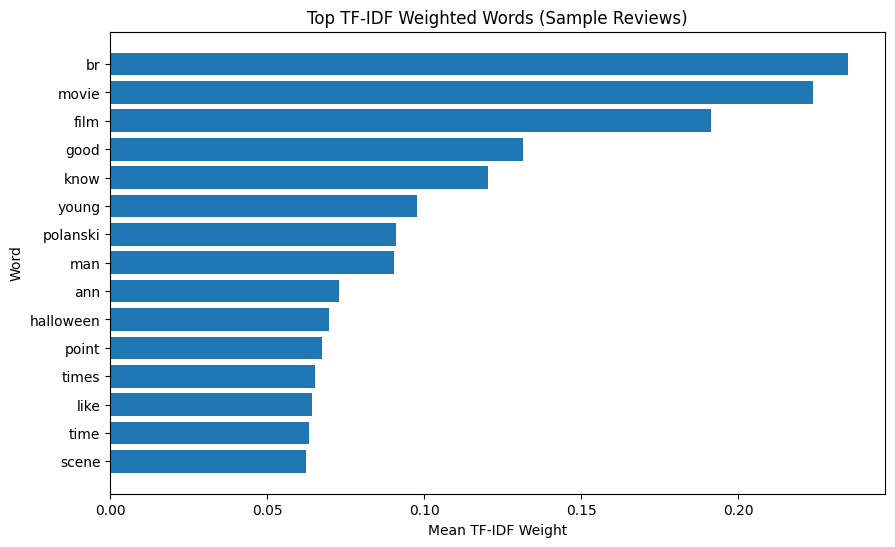

In [14]:

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Sample subset for visualization
sample = df['review'][:10]
tfidf = TfidfVectorizer(max_features=20, stop_words='english')
X_tfidf = tfidf.fit_transform(sample)
features = tfidf.get_feature_names_out()

# Mean TF-IDF scores across docs
mean_scores = X_tfidf.mean(axis=0).A1
sorted_idx = mean_scores.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.barh([features[i] for i in sorted_idx][:15], mean_scores[sorted_idx][:15])
plt.gca().invert_yaxis()
plt.title("Top TF-IDF Weighted Words (Sample Reviews)")
plt.xlabel("Mean TF-IDF Weight")
plt.ylabel("Word")
plt.show()


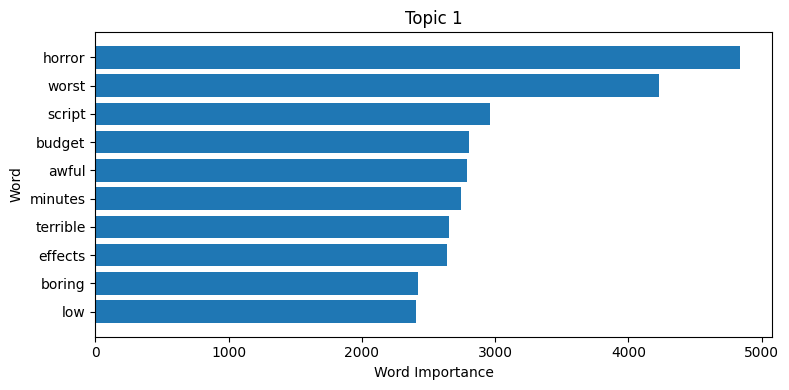

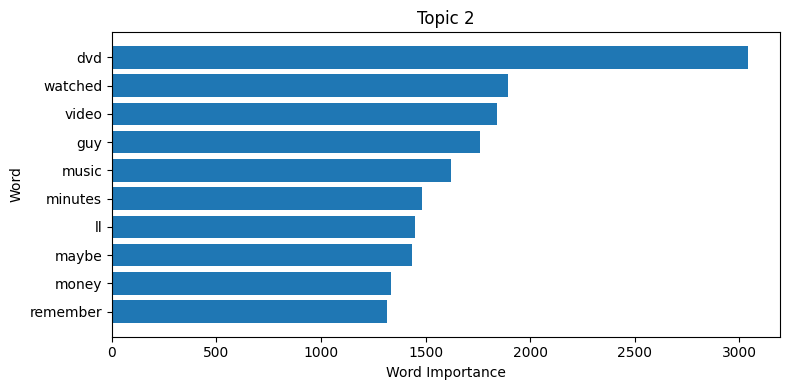

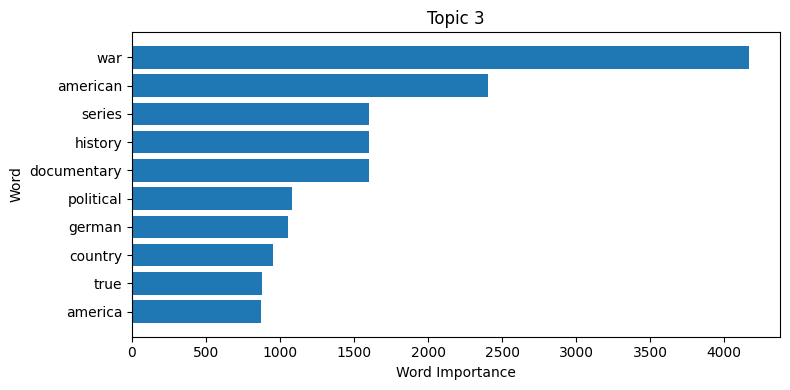

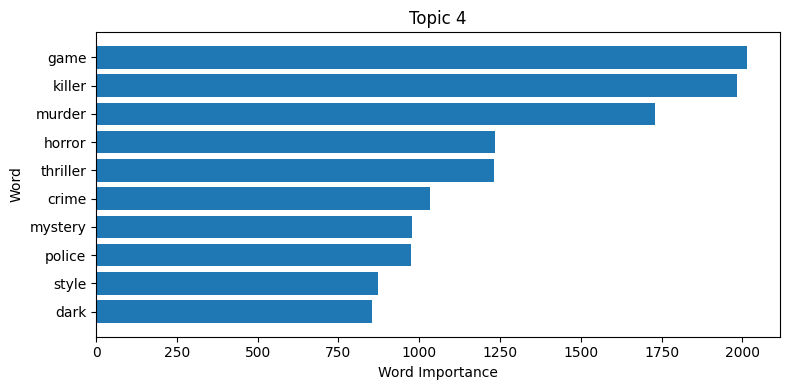

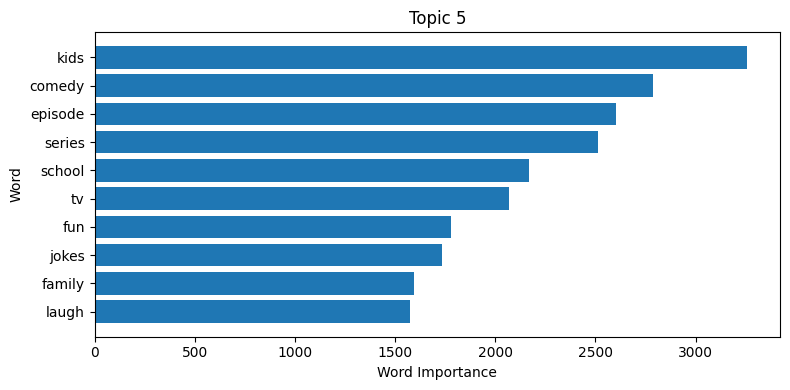

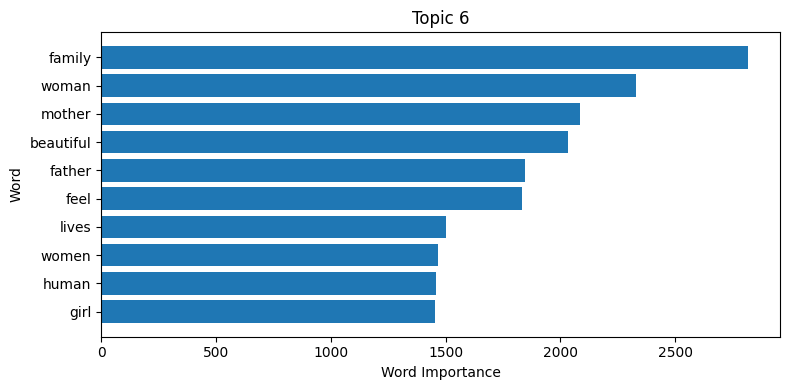

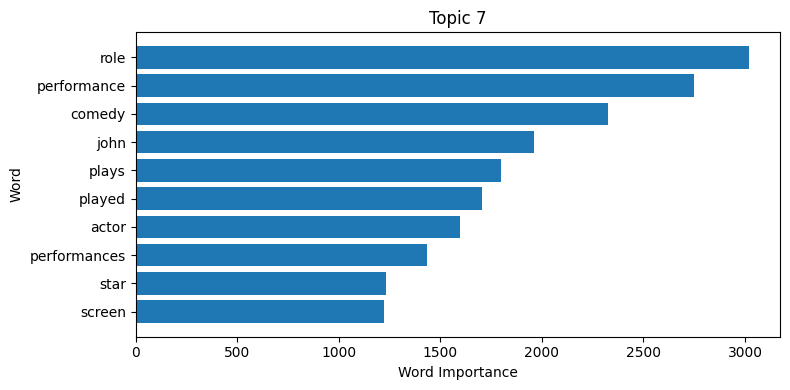

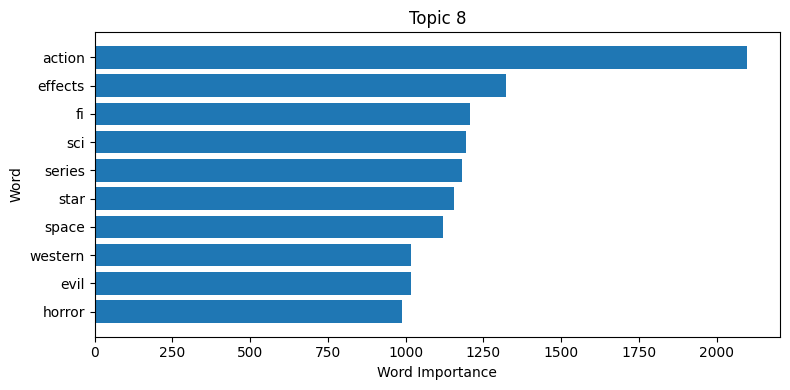

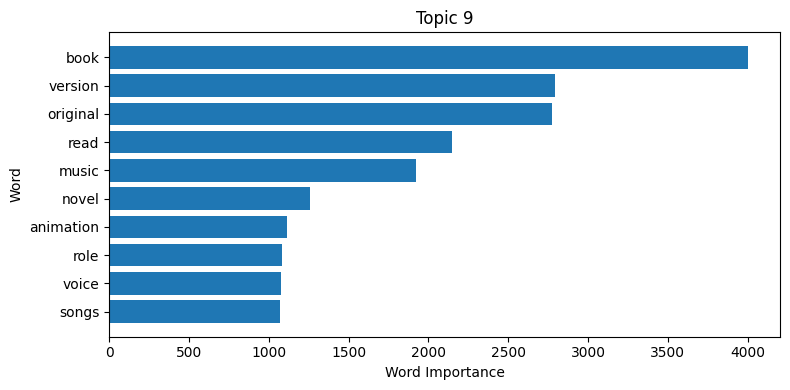

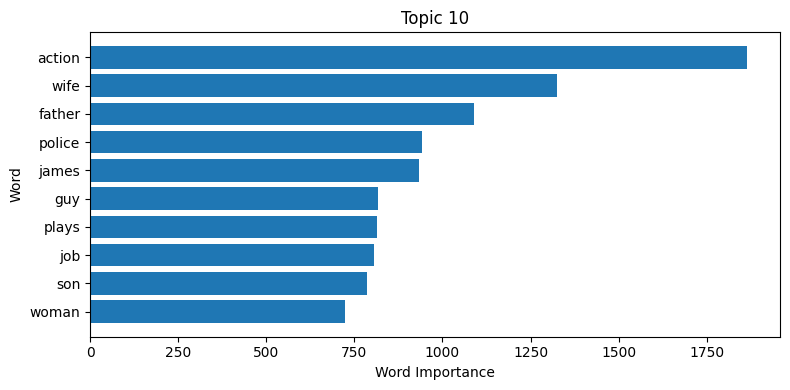

In [15]:
import numpy as np
import matplotlib.pyplot as plt

n_top_words = 10
feature_names = count.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    weights = topic[topic.argsort()[:-n_top_words - 1:-1]]
    plt.figure(figsize=(8,4))
    plt.barh(top_features[::-1], weights[::-1])
    plt.title(f"Topic {topic_idx + 1}")
    plt.xlabel("Word Importance")
    plt.ylabel("Word")
    plt.tight_layout()
    plt.show()
